# Описание проекта

Проект разбит на 2 больших блока. 1й - посвящен анализу данных и их обработке. 2й состоит из обучения ML модели и предсказания на ее базе жанров музыки в тестовой выборке.

Первый блок состоит из следущих шагов:
1) Импорт данныхд. 
В проекте применены библиотеки pandas, phik, langdetect, CatBoost, shap.

2) Предобраюотка дынных.
На этом этапе заполнены пропуски в данных.

3) Разработка синтетических данных.
Определение дополнительных признаков на базе названия треков.

4) Проверка на мультиколлинеарность. Использована библиотека phik (одновременно умеет работать с различными типами признаков: числовые, категориальные, бинарные, ранговые и тд). https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7

3) В проекте не использованы sklearn.pipeline (Технология пайплайн - цель для дополнительного внедрения в модель на этапе доработки проекта). Статьи про Pipeline и Сolumntransformer https://medium.com/mlearning-ai/neat-data-preprocessing-with-pipeline-and-columntransformer-2a0468865b6b https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156
Статья про Pipeline и GridSearchCV - https://towardsdatascience.com/an-introduction-to-building-pipelines-and-using-grid-searches-in-scikit-learn-92ea72f9b5b7

4) На базе проекта будет разраьотан отчет на этапе публикации проекта на гитхаб - отчеты по финальным проектам направления Machine Learning - https://cs229.stanford.edu/projects2014.html. Из примеров понятно наполнение отчета по исследованию, а так же, что главное - понятна сама структура отчета.

5)В проекте частично реализована оценка важности признаков. Можно воспользоваться встроенными стредствами в моделях (например атрибут у «деревянных» моделей feature_importances_). Вот хорошая обзорная статья по этой теме, где рассматриваются несколько методов из библиотеки sklearn - https://medium.com/analytics-vidhya/feature-importance-explained-bfc8d874bcf
Библиотека shap — позволяет детально изучить работу модели, в том числе оценить важность признаков, при этом не привязана к работе конкретного алгортима прогнозирования. Вот статья с описанием ее работы — https://habr.com/ru/articles/428213/ и детальный разбор графиков - https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137

6) В ML модели реализован метод GridSearchCV для подбора гиперпараметров. Можно использовать более продвинутые (и эффективные) методы — почитайте про библиотеку scikit-optimize и ее методы - https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html. Так же есть библиотека optuna, но ее использование сложнее чем все предыдущие методы — вот статья на русском https://habr.com/ru/articles/704432/

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Спасибо тебе за столь развернутое описание проекта и выполняемых действий!👍🏼 Стоит более более подробно описать саму задачу и имеющиеся данные.</div>


# Импорт данных и библиотек / Data & libraries import 

**Installation**


In [1]:
#conda install -c conda-forge langdetect
#pip install catboost
# pip install phik
# conda install -c conda-forge shap

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler

from catboost import CatBoostClassifier
from catboost import cv, Pool
from lightgbm import LGBMClassifier


from tqdm import notebook
from tqdm import tqdm
import time
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords as nltk_stopwords

import phik
from phik.report import plot_correlation_matrix
from phik import report

import shap

In [3]:
#Global veriables
RANDOM_STATE = 12345
nltk.download('stopwords')
stop_words_set = set(nltk_stopwords.words('english'))
stop_words_list = list(stop_words_set) 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimgorskov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Примечание.
Для корректной работы всего кода и выполнения его дальнейшей логики - необходимо указать в переменной **DATA_DIR** путь к локальному файлу с данными.

In [4]:
DATA_DIR = '/Users/maksimgorskov/Desktop/Data Science/Мастерская_1_rev.1 (Предсказание жанра музыки)/Финальная работа/'
music_df = pd.read_csv(DATA_DIR +'kaggle_music_genre_train.csv')
music_test = pd.read_csv(DATA_DIR +'kaggle_music_genre_test.csv')

Описание полей данных

- instance_id - уникальный идентификатор трека
- track_name - название трека
- acousticness - акустичность
- danceability - танцевальность
- duration_ms -продолжительность в милисекундах
- energy - энергичность
- instrumentalness - инструментальность
- key
- liveness - привлекательность
- loudness - громкость
- mode
- speechiness - выразительность
- tempo - темп
- obtained_date - дата загрузки в сервис
- valence - привлекательность произведения для пользователей сервиса
- music_genre - музыкальный жанр

# Data preprocessing

## Main info

In [5]:
#Function for data analys
def data_info(df):
    print('Размерность данных:')
    print(df.shape)
    print()
    print('Общее знакомство с данными:')
    df.info()
    print()
    print(f'Количество дубликатов в наборе данных: {df.duplicated().sum()}')
    print()
    print('Пропущенные значения:')
    display(pd.DataFrame({'% пропущенных значений': df.isna().mean()}))
    

In [6]:
data_info(music_df)

Размерность данных:
(20394, 16)

Общее знакомство с данными:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 no

,% пропущенных значений
instance_id,0.000000
track_name,0.000000
acousticness,0.000000
danceability,0.000000
duration_ms,0.000000
energy,0.000000
instrumentalness,0.000000
key,0.036040
liveness,0.000000
loudness,0.000000


In [7]:
music_df.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.000000,20394.000000,20394.000000,2.039400e+04,20394.000000,20394.000000,20394.000000,20394.000000,20394.000000,19952.000000,20394.000000
mean,55973.846916,0.274783,0.561983,2.203754e+05,0.625276,0.159989,0.198540,-8.552998,0.091352,120.942522,0.464588
std,20695.792545,0.321643,0.171898,1.267283e+05,0.251238,0.306503,0.166742,5.499917,0.097735,30.427590,0.243387
min,20011.000000,0.000000,0.060000,-1.000000e+00,0.001010,0.000000,0.013600,-44.406000,0.022300,34.765000,0.000000
25%,38157.250000,0.015200,0.451000,1.775170e+05,0.470000,0.000000,0.097300,-10.255750,0.035600,95.921750,0.272000
50%,56030.000000,0.120000,0.570000,2.195330e+05,0.666000,0.000144,0.130000,-7.052000,0.049050,120.012500,0.457000
75%,73912.750000,0.470000,0.683000,2.660000e+05,0.830000,0.084475,0.253000,-5.054000,0.095575,141.966250,0.653000
max,91758.000000,0.996000,0.978000,4.497994e+06,0.999000,0.996000,1.000000,3.744000,0.942000,220.041000,0.992000


**Описание датафрейма в тезисах:**

- Датафрейм представляет собой набор данных с 20394 записями и 16 признаками.
- Типы данных соответтсвуют ожидаемым.
- Дубликаты отсутствуют.
- Пропуски наблюдаются в следующих признаках: 'key', 'mode', 'tempo'. Пропуски в каждом признаке не превышают 4% от общего количества записей в каждом из признаков.
- В датафрейме присутствуют отрицательные значения в признаках 'duration_ms' и 'loudness'.

## Description of categorical features.

In [8]:
cat_columns = [col for col in music_df.columns if music_df[col].dtype == 'object']

In [9]:
for i in cat_columns:
    print(music_df[i].unique())

['Highwayman' 'Toes Across The Floor' 'First Person on Earth' ...
 'Original Prankster' '4Peat' 'Trouble (feat. MC Spyder)']
['D' 'A' 'E' 'G#' 'C' 'D#' 'A#' 'F' 'F#' nan 'G' 'C#' 'B']
['Major' 'Minor' nan]
['4-Apr' '3-Apr' '5-Apr' '1-Apr']
['Country' 'Rock' 'Alternative' 'Hip-Hop' 'Blues' 'Jazz' 'Electronic'
 'Anime' 'Rap' 'Classical']


Категориальные признаки, за исключением наименования треков можно использовать для описания статистики.

In [10]:
cat_columns = cat_columns[1:]

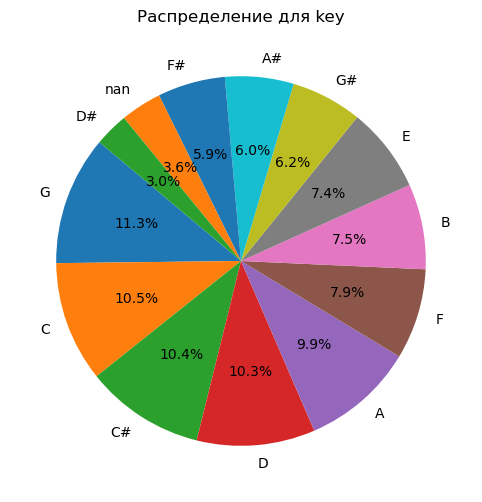

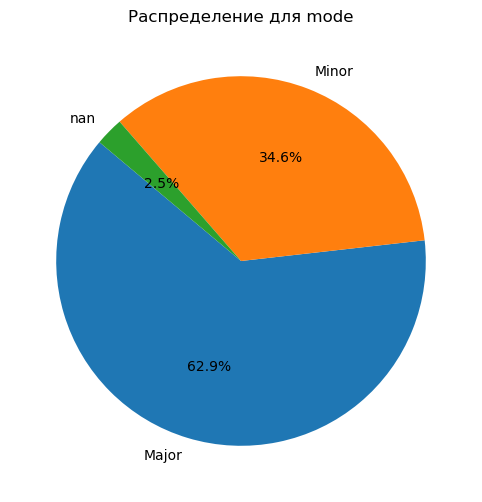

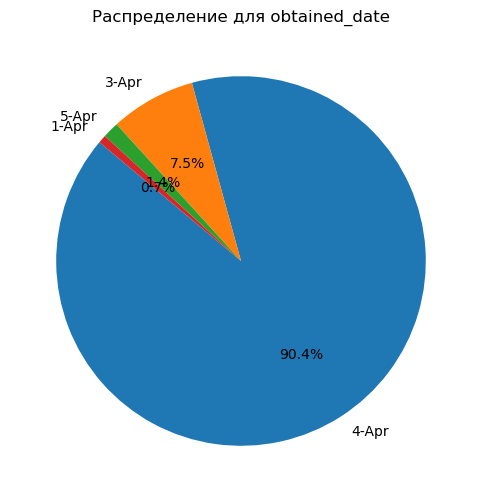

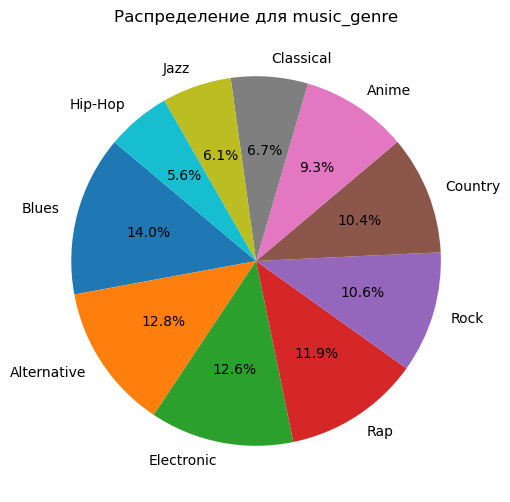

In [11]:
#Создаем круговые диаграммы для каждого категориального признака
for col in cat_columns:
    # Получаем распределение значений
    distribution = music_df[col].value_counts(dropna=False)  # dropna=False включает в подсчет NaN значения
    
    # Создаем круговую диаграмму
    plt.figure(figsize=(8, 6))
    plt.pie(distribution, labels=distribution.index, autopct='%1.1f%%', startangle=140)
    plt.title(f'Распределение для {col}')
    plt.show()

**Вывод / Conclussion**:

- 'key' - классы данного признака имеют дисбаланс. Максимальное и минимальное количество разныых классов относятся друг к другу более чем в 3 раза.
- 'mode' - классы данного признака имеют дисбаланс. Максимальное и минимальное количество разныых классов относятся друг к другу более чем в 2 раза.
- 'obtained_date' - классы данного признака имеют дисбаланс. Максимальное и минимальное количество разныых классов относятся друг к другу более чем в 10 раза.
- 'mode' - классы данного признака имеют дисбаланс. Максимальное и минимальное количество разныых классов относятся друг к другу более чем в 2 раза.
- В названиях треков имеется большое количество данных, которые могут быть использованы для формирования дополнительных признаков. С помощью технологий NLP таковые могут быть сформированы.


## Description of numeric features.

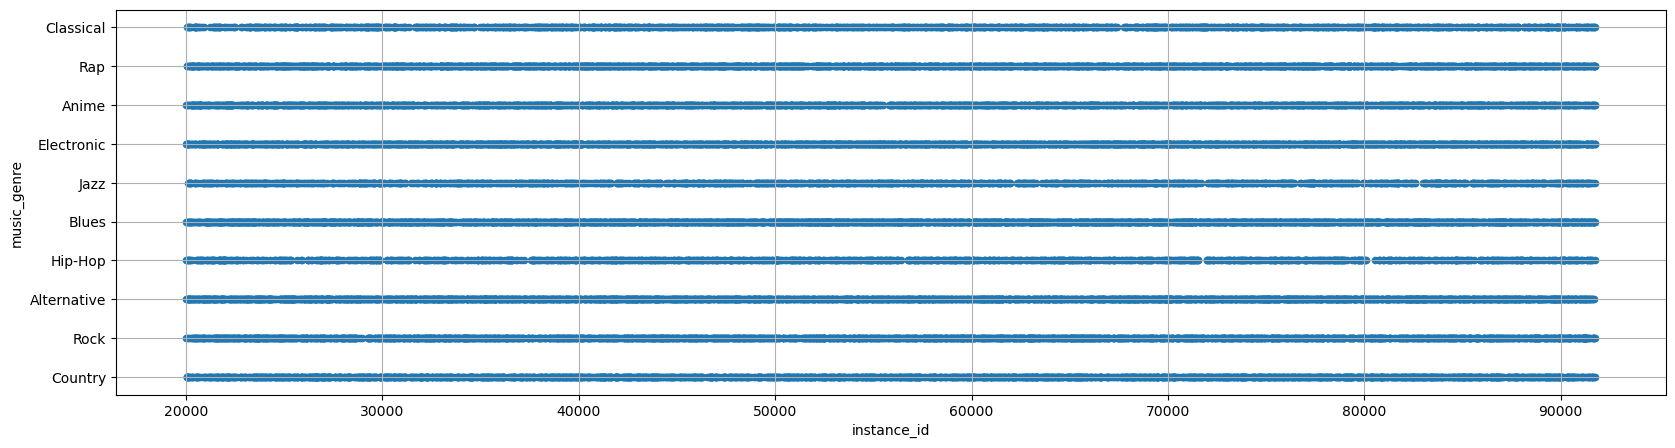

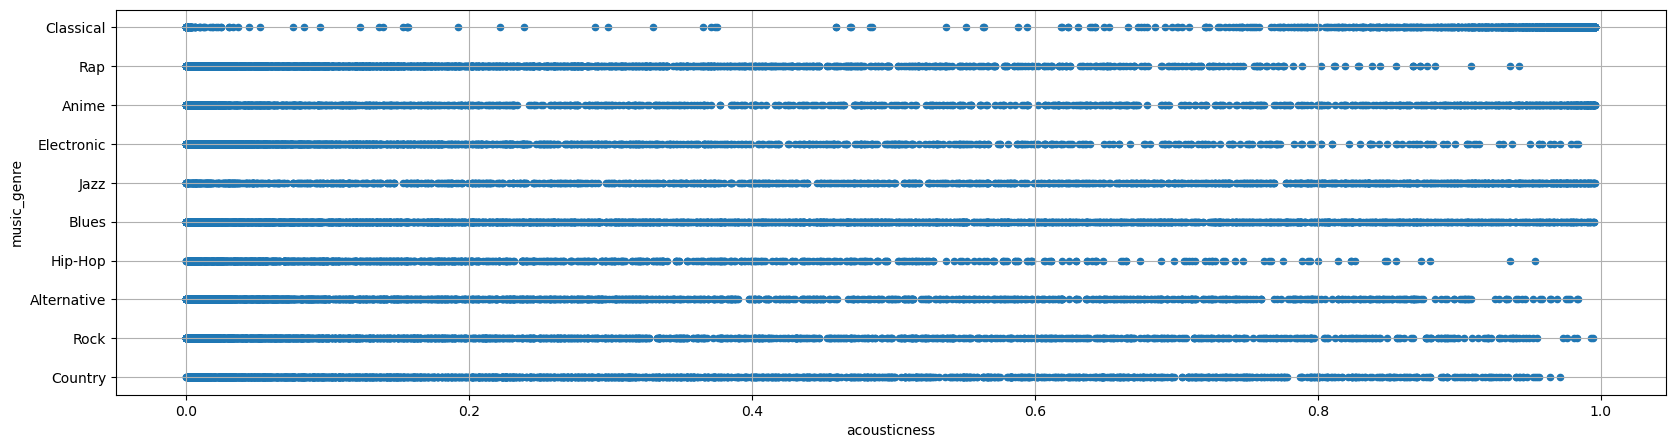

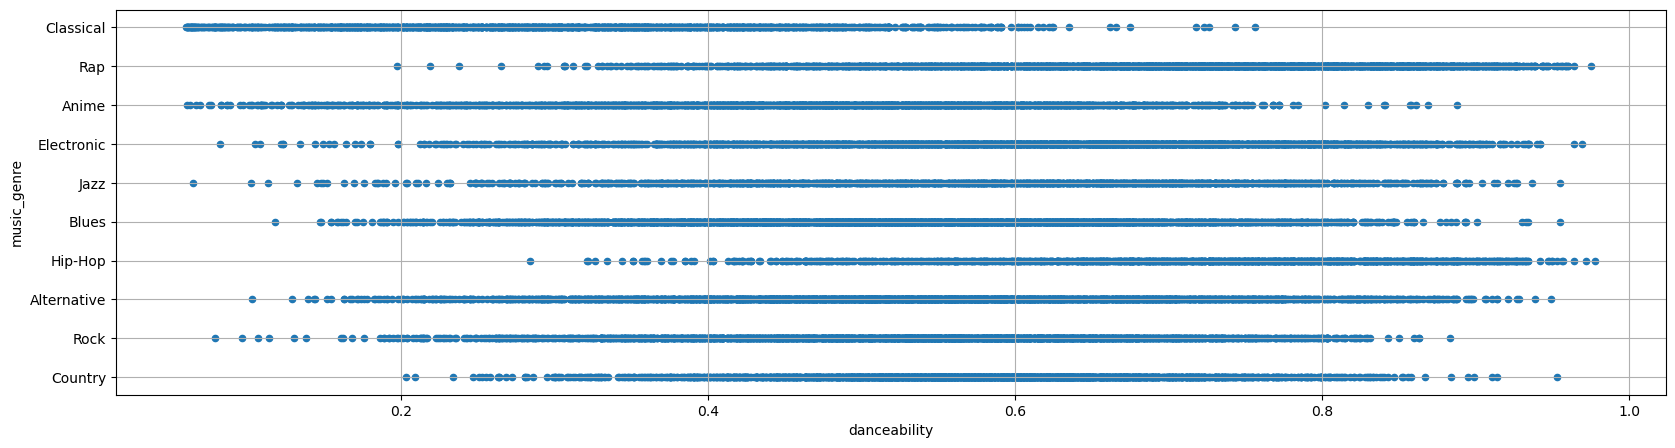

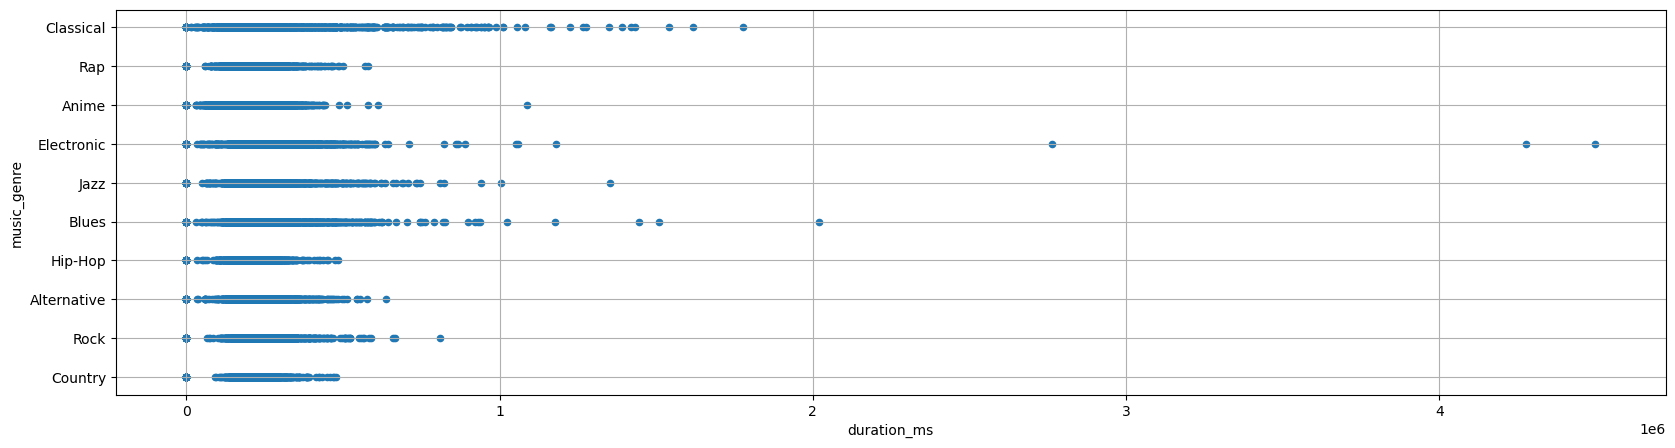

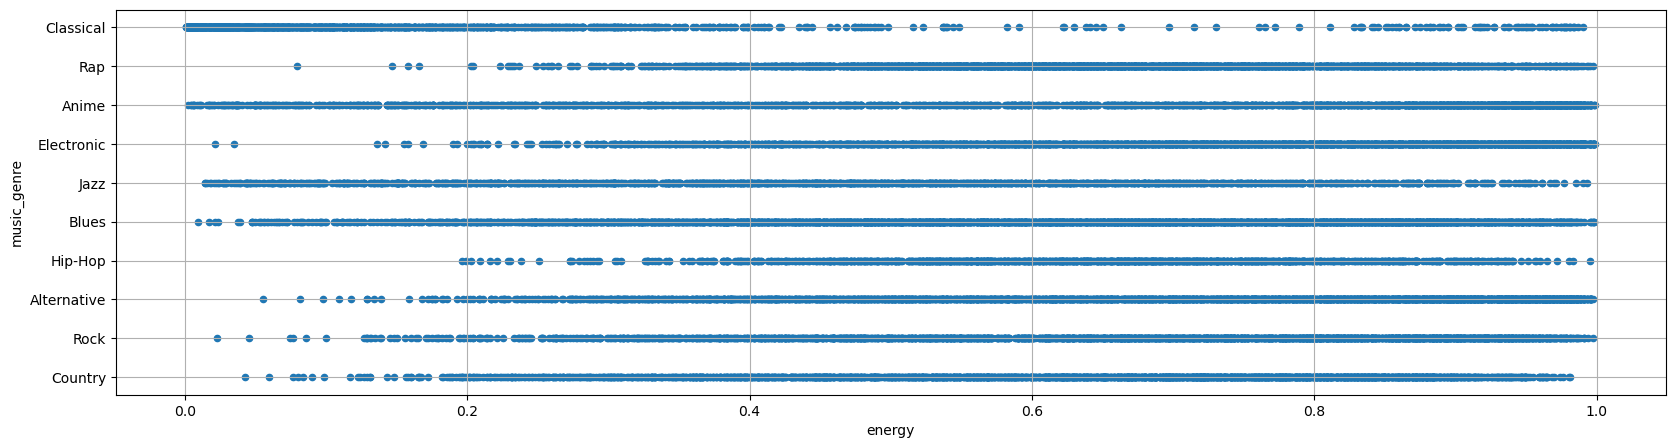

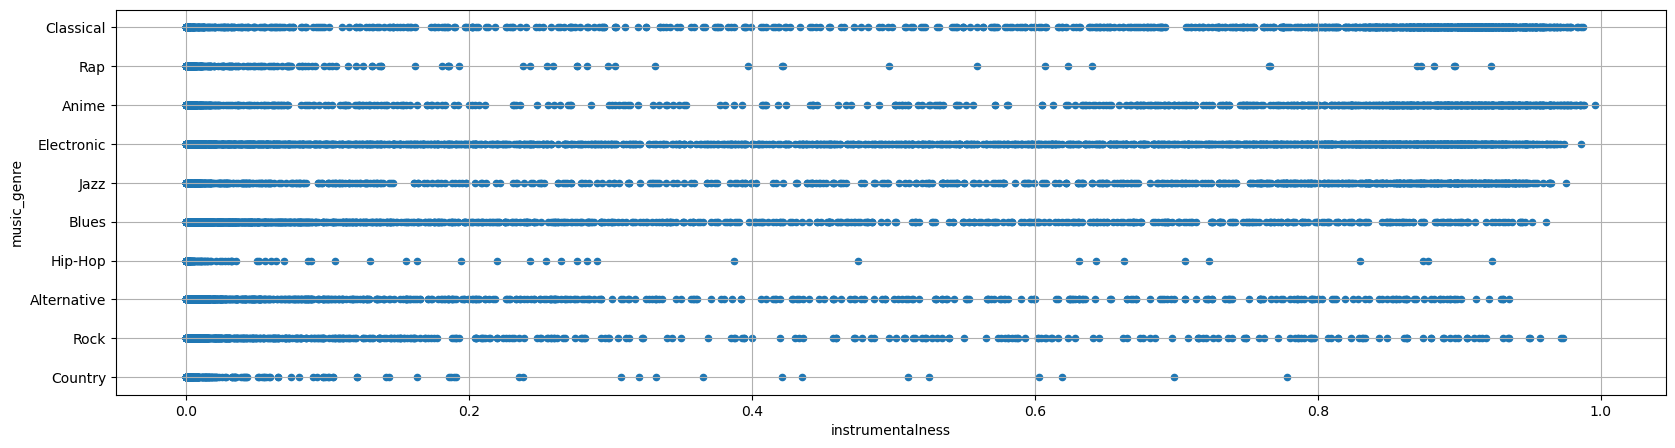

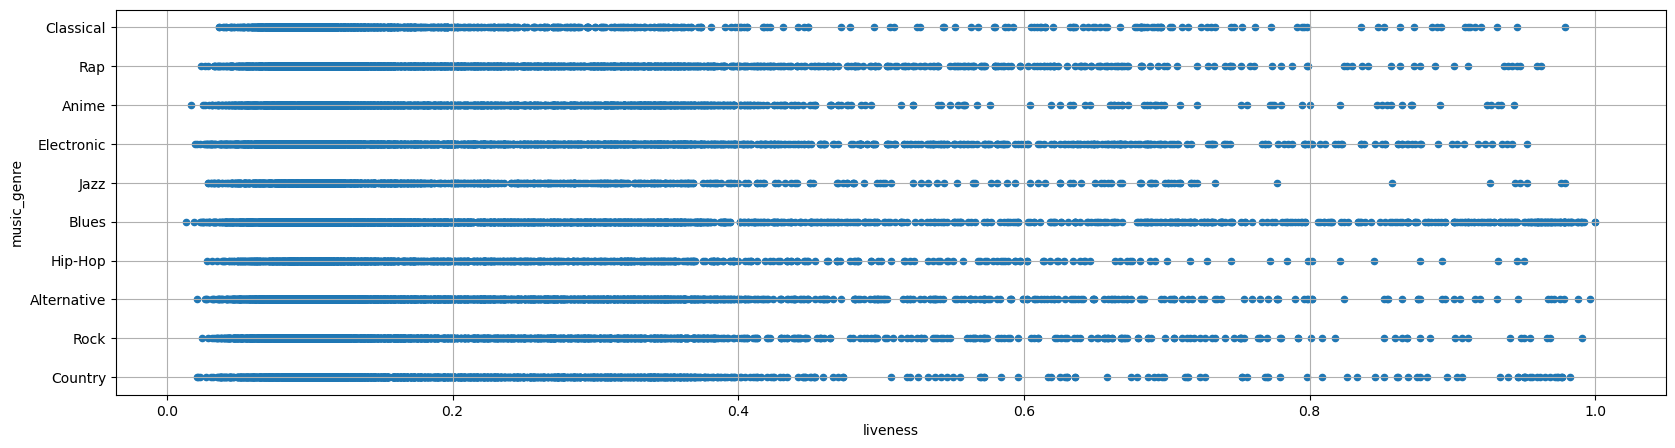

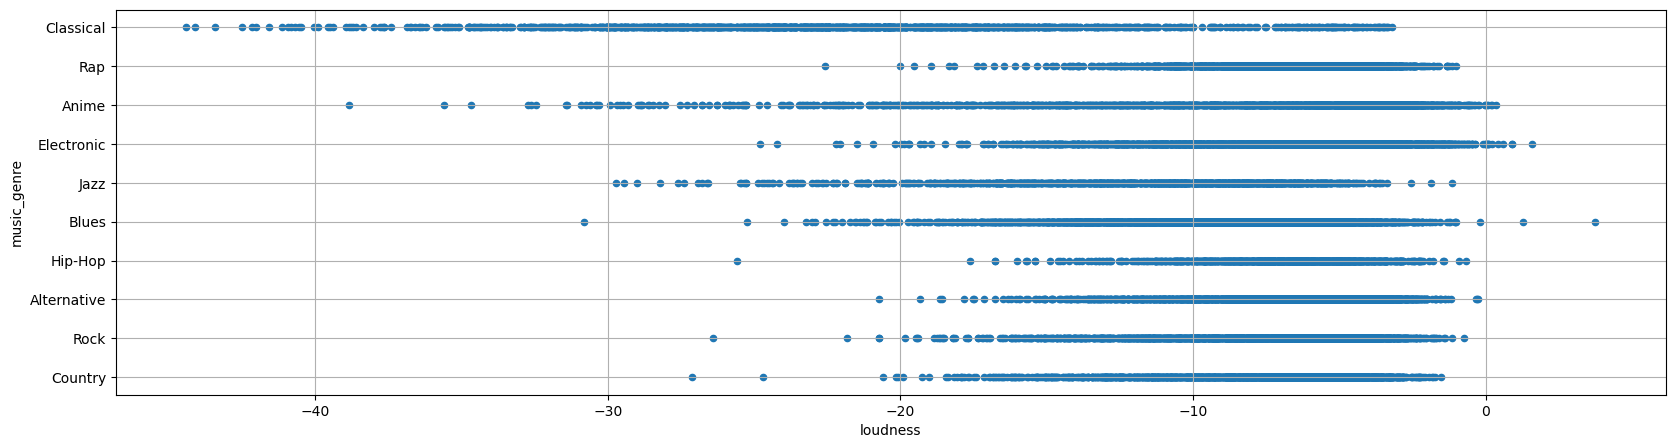

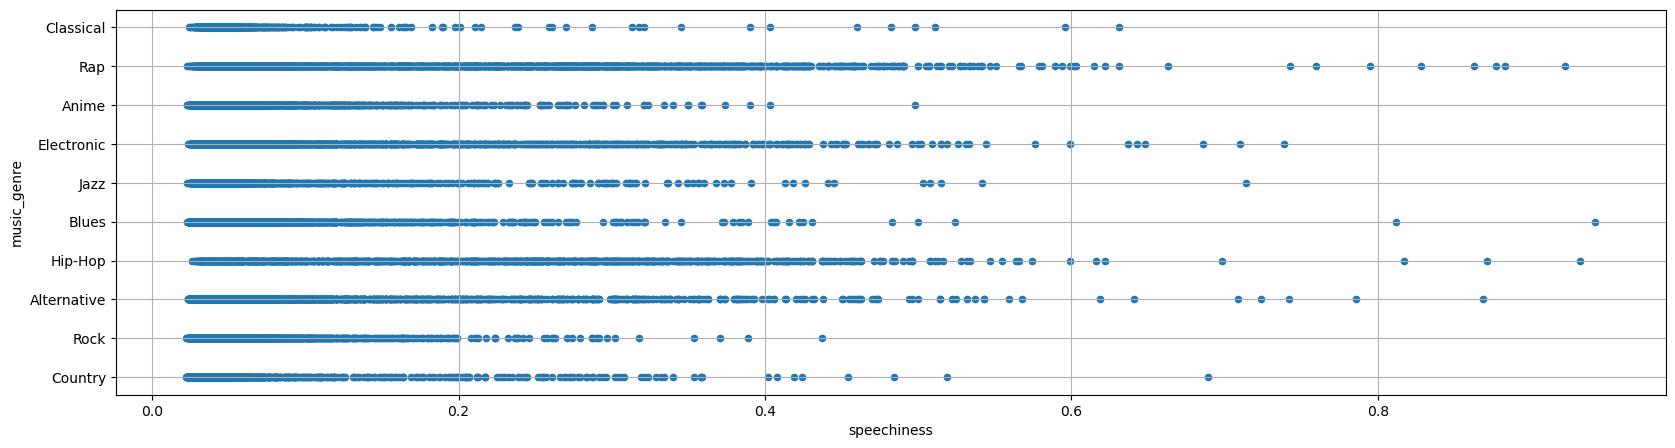

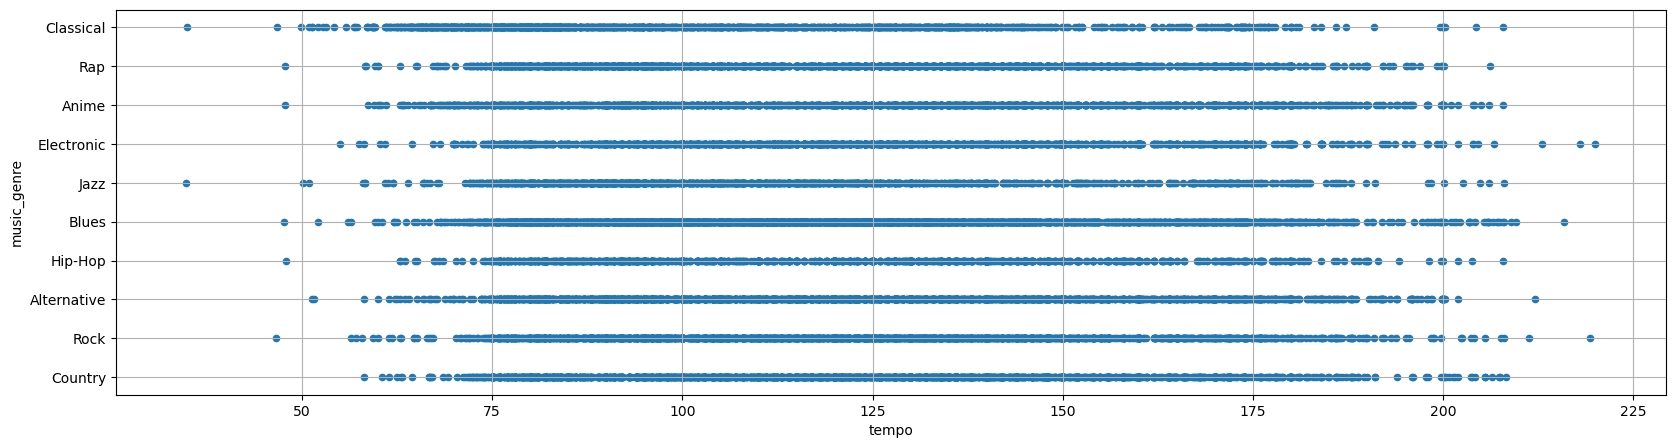

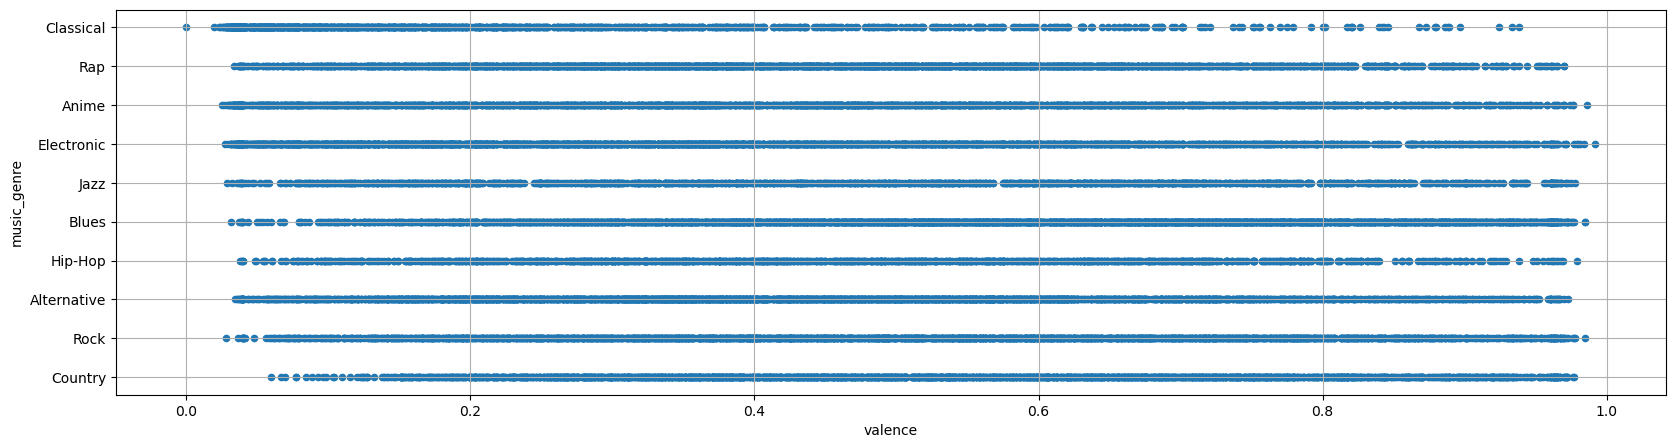

In [12]:
# Data anomaly reserch
#Создание списка столбцов, где тип данных является float64
float_columns = [col for col in music_df.columns if music_df[col].dtype == 'float64']

for i in float_columns:
    music_df.plot(kind = 'scatter', y = 'music_genre', x = i, grid = True, legend=True, figsize = (20,5))

Вывод / Conclussion:

- В рамках исследования, было выявлено, что исключение выбросов по методике "ящик с усами" приводят к утере данных, и снижению метрики F1. Было принято решение разрабатывать модель ML на всех признаках датасета.

- In reserch borders it was found out that deliting of blow outs will cose data lickage. And final metric volume decline.

## Missed data fealing. 

***
**Все категориальные значения заполняются по следующей логике:**
- Для каждого жанра музыки пропуски заполняются наиболее частым значением.

**Все числовые значения заполняются по следующей логике:**
- Для каждого музыкального ключа пропуски заполняются по медианому значению.
***

**Примечание:**
В общепринятой практике считается, что заполнение пропусков не может опираться на целевой признак.
Однако в рамках соревнования при проведении эксперемента выявлено следующее:
- Заполнение пропусков в тренировочной выборке значениями по указанному принципу улучшает качество модели.

Это можно обьяснить тем, что заполнение пропусков в тренировочной выборке позволяет модели максимально хорошо обучиться на данных, и в дальнейшем, ошибки при заполнении пропусков на тренировочной выборке будут приводить к небольшим потерям в качестве работы модели. 


In [13]:
# Проверяем наличие пропущенных значений в каждом столбце
columns_with_na = music_df.isna().any()

# Выводим имена столбцов, где есть пропущенные значения
columns_with_na = columns_with_na[columns_with_na].index.tolist()

In [14]:
print(f'Пропуски присутствуют в следующих столбцах: {columns_with_na}')

Пропуски присутствуют в следующих столбцах: ['key', 'mode', 'tempo']


In [15]:
music_genre = music_df['music_genre'].value_counts().to_frame().reset_index()
music_genre

,music_genre,count
0,Blues,2858
1,Alternative,2601
2,Electronic,2564
3,Rap,2428
4,Rock,2165
5,Country,2120
6,Anime,1901
7,Classical,1373
8,Jazz,1239
9,Hip-Hop,1145


In [16]:
for col in columns_with_na:
    #Заполнение категориальных признаков.
    if music_df[col].dtype ==  'object':
        for i_genre in range(len(music_genre['music_genre'])):
            genre = music_genre['music_genre'][i_genre]
            # Получаем индекс для всех строк, удовлетворяющих условию
            val_to_fill = music_df.loc[music_df['music_genre'] == genre, col].value_counts().idxmax()
            # Заполняем пропущенные значения в столбце 'key' для этих строк
            music_df[col] = music_df[col].fillna(val_to_fill)
    
    #Заполнение числовых признаков        
    else: 
        music_df[col] = music_df[col].fillna(music_df[col].median())

    if music_df[col].isna().sum() == 0:
        print(f'В признаке {col} пропуски отсутсвуют.')
    else:
        print(f'Код работает некорректно с признаком {col}.')

В признаке key пропуски отсутсвуют.
В признаке mode пропуски отсутсвуют.
В признаке tempo пропуски отсутсвуют.


## Features with negative volume.

**Duration.**

In [17]:
music_df['duration_ms'].value_counts()

duration_ms
-1.0         2009
 240000.0      16
 192000.0      16
 180000.0      13
 182400.0      10
             ... 
 198286.0       1
 142213.0       1
 368083.0       1
 223237.0       1
 271885.0       1
Name: count, Length: 13649, dtype: int64

In [18]:
#Replace all -1 duration for median df class duration

for genre in list(music_df['music_genre'].unique()):
    music_df.loc[(music_df['duration_ms'] == -1) & (music_df['music_genre'] == genre), 'duration_ms'] =\
     music_df['duration_ms'].mean()


**Loudness**.

This feature also is used like negtive volume. It shouldn't be changed.

In [19]:
music_df.isna().sum()

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64

## Conclusion.

Тренировочная выборка предобработана и готова для использования.
- Типы данных соответтсвуют ожидаемым.
- Дубликаты отсутствуют.
- Пропуски отсутствуют.
- Все значения признаков соответствуют требуемым.

# BaseLine model

In [20]:
# X - features, y - target
y = music_df['music_genre']
X = music_df.drop('music_genre', axis = 1)

To understand how ML model is working in first approximation we will create the CatBosstClassification with base hyperpameters.  

In [21]:
cat_X = list(X.select_dtypes(include = 'object').columns)

cat_features = [] #Принимает индексы всех категориальных значений  
for i in range(len(X.columns)):
    if X.columns[i] in cat_X:
        cat_features.append(i)
cat_features

[1, 7, 10, 13]

In [22]:
# Features partition for 2 samples
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify = y, test_size = 0.25, random_state = RANDOM_STATE)

In [23]:
pool = Pool(data=X, label=y, cat_features = cat_features)

In [24]:
classes = y.unique()
classes

weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [25]:
# cbc_model = CatBoostClassifier()
cbc_model = CatBoostClassifier(
    iterations = 1000,
    loss_function='MultiClass',
    eval_metric = 'MultiClass',
    early_stopping_rounds=50,
    random_seed = RANDOM_STATE
)

# Fit model
cbc_model.fit(
    X_train, y_train,
    cat_features = cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [26]:
# F1 metric calculation
f1_blm = f1_score(y_valid,cbc_model.predict(X_valid), average = 'micro')
f1_blm

0.5252010198078054

На каждом этапе проекта результаты будут вноситсья в сводную таблицу, для анализа динамики изменения целевой метрики.

In [27]:
result_df = pd.DataFrame(columns = ['ML_model', 'model_description', 'f1'])

In [28]:
#Добавление результата модели BaseLine:
append_df = pd.DataFrame({
    'ML_model' : ['CatBoostClassifier'],
    'model_description' : ['BaseLineModel'],
    'f1' : [f1_blm]}
)

In [29]:
result_df = pd.concat([result_df, append_df], ignore_index=True)
result_df

,ML_model,model_description,f1
0,CatBoostClassifier,BaseLineModel,0.525201


# NLP

## Лемметизация и чистка текста.

In [30]:
#Функция для чистки текста от лишних символов.
def text_preprocessing(text):
    tokenized = nltk.word_tokenize(text)
    joined = ' '.join(tokenized)
    text_only = re.sub(r"[^a-z0-9!@#\$%\^\&\*_\-,\.' ]", ' ', joined)
    final = ' '.join(text_only.split())
    return final

In [31]:
#Применение функции очистки к фрейму данных.
tqdm.pandas()
music_df['track_name'] = music_df['track_name'].progress_apply(text_preprocessing)

100%|██████████████████████████████████| 20394/20394 [00:00<00:00, 31554.48it/s]


In [32]:
music_df['track_name']

0                    ighwayman
1            oes cross he loor
2           irst erson on arth
3        o e eo - igital ingle
4                hasing hadows
                 ...          
20389                      ato
20390            t . ashington
20391         riginal rankster
20392                    4 eat
20393      rouble feat . pyder
Name: track_name, Length: 20394, dtype: object

Текс леммитизирован.

## Добавление TF-IDF.

В работе признак 'tempo' появляется более 1 раза. В связи с тем, что при создании мешка слов и добавления его в датафрейм появляется аналогичное название.

In [104]:
#Замена наименования изначального признака 'tempo'
music_df = music_df.rename(columns={'tempo': 'tempo_feature'})

In [105]:
#Выделение корпуса текстов
corpus = music_df['track_name'] 

In [106]:
count_tf_idf = TfidfVectorizer(stop_words=stop_words_list)

In [107]:
tf_idf_train_res = count_tf_idf.fit_transform(corpus) 
print(f'Размер матрицы для обучения: {tf_idf_train_res.shape}')

Размер матрицы для обучения: (20394, 10794)


## Добавление признаков TF-IDF к фрэйму данных.

In [37]:
tf_idf_df = pd.DataFrame(tf_idf_train_res.toarray(), columns=count_tf_idf.get_feature_names_out())
tf_idf_df.head()

,00,000,001,01,02,03,04,05,06,07,...,zikra,zu,zucar,zul,zum,zuna,zure,zweiten,zz,zzy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
music_df_tfidf = pd.concat([music_df, tf_idf_df], axis = 1)
music_df_tfidf.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,...,zikra,zu,zucar,zul,zum,zuna,zure,zweiten,zz,zzy
0,25143.0,ighwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,26091.0,oes cross he loor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,87888.0,irst erson on arth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,77021.0,o e eo - igital ingle,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20852.0,hasing hadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Разработка модели ML

In [39]:
# X - features, y - target
y = music_df_tfidf['music_genre']
X = music_df_tfidf.drop(['music_genre', 'instance_id'], axis = 1)

## CatBoostClassifier

In [40]:
cat_X = list(X.select_dtypes(include = 'object').columns)

cat_features = [] #Принимает индексы всех категориальных значений  
for i in range(len(X.columns)):
    if X.columns[i] in cat_X:
        cat_features.append(i)
cat_features

[0, 6, 9, 12]

In [41]:
# Features partition for 2 samples
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, stratify = y, test_size = 0.25, random_state = RANDOM_STATE)

In [42]:
pool = Pool(data=X, label=y, cat_features = cat_features)

In [43]:
classes = y.unique()

weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

In [44]:
%%time
# cbc_model = CatBoostClassifier()
cbc_model = CatBoostClassifier(
    learning_rate = 0.1,
    iterations = 5000,
    loss_function='MultiClass',
    eval_metric = 'MultiClass',
    early_stopping_rounds=50,
    verbose=0,
    random_seed = RANDOM_STATE
)

# Fit model
cbc_model.fit(
    X_train, y_train,
    cat_features = cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CPU times: user 32min 57s, sys: 25.5 s, total: 33min 22s
Wall time: 4min 21s


In [45]:
# F1 metric calculation
f1_cbc = f1_score(y_valid,cbc_model.predict(X_valid), average = 'micro')
f1_cbc

0.5328495783486958

In [46]:
#Добавление результата модели BaseLine:
append_df = pd.DataFrame({
    'ML_model' : ['CatBoostClassifier'],
    'model_description' : ['CatBoostClassifier Model after feature engineering, cross-validation, and hyperparameter tuning'],
    'f1' : [f1_cbc]}
)

In [47]:
result_df = pd.concat([result_df, append_df], ignore_index=True)
result_df

,ML_model,model_description,f1
0,CatBoostClassifier,BaseLineModel,0.525201
1,CatBoostClassifier,CatBoostClassifier Model after feature enginee...,0.532850


# Multycalliniarity analisys

To understand if some features are influence for others and duplicate coillation with target feature we will conduct Multycalliniarity analisys using 𝜙k library.

В анализе используются только изначальные признаки.

In [48]:
#Матрица корреляции / Correlation matrix
phik_music_df = music_df.phik_matrix()
phik_music_df.round(2)


interval columns not set, guessing: ['instance_id', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo_feature', 'valence']


The number of unique values of variable track_name is large: 17649. Are you sure this is not an interval variable? Analysis for pairs of variables including track_name can be slow.


,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo_feature,obtained_date,valence,music_genre
instance_id,1.00,0.14,0.00,0.03,0.03,0.00,0.00,0.01,0.02,0.00,0.02,0.00,0.00,0.02,0.00,0.00
track_name,0.14,1.00,0.91,0.92,1.00,0.90,0.92,0.87,0.92,0.96,0.62,0.87,0.90,0.90,0.89,0.76
acousticness,0.00,0.91,1.00,0.46,0.13,0.77,0.44,0.10,0.19,0.71,0.03,0.20,0.33,0.26,0.40,0.66
danceability,0.03,0.92,0.46,1.00,0.17,0.52,0.34,0.10,0.14,0.48,0.10,0.34,0.40,0.29,0.53,0.62
duration_ms,0.03,1.00,0.13,0.17,1.00,0.14,0.17,0.04,0.09,0.17,0.01,0.03,0.08,0.04,0.14,0.20
energy,0.00,0.90,0.77,0.52,0.14,1.00,0.44,0.09,0.26,0.84,0.03,0.24,0.38,0.29,0.48,0.67
instrumentalness,0.00,0.92,0.44,0.34,0.17,0.44,1.00,0.03,0.14,0.50,0.08,0.19,0.22,0.13,0.36,0.57
key,0.01,0.87,0.10,0.10,0.04,0.09,0.03,1.00,0.06,0.08,0.34,0.11,0.04,0.07,0.04,0.17
liveness,0.02,0.92,0.19,0.14,0.09,0.26,0.14,0.06,1.00,0.20,0.03,0.14,0.09,0.04,0.13,0.21
loudness,0.00,0.96,0.71,0.48,0.17,0.84,0.50,0.08,0.20,1.00,0.02,0.21,0.35,0.25,0.44,0.68


The figure layout has changed to tight


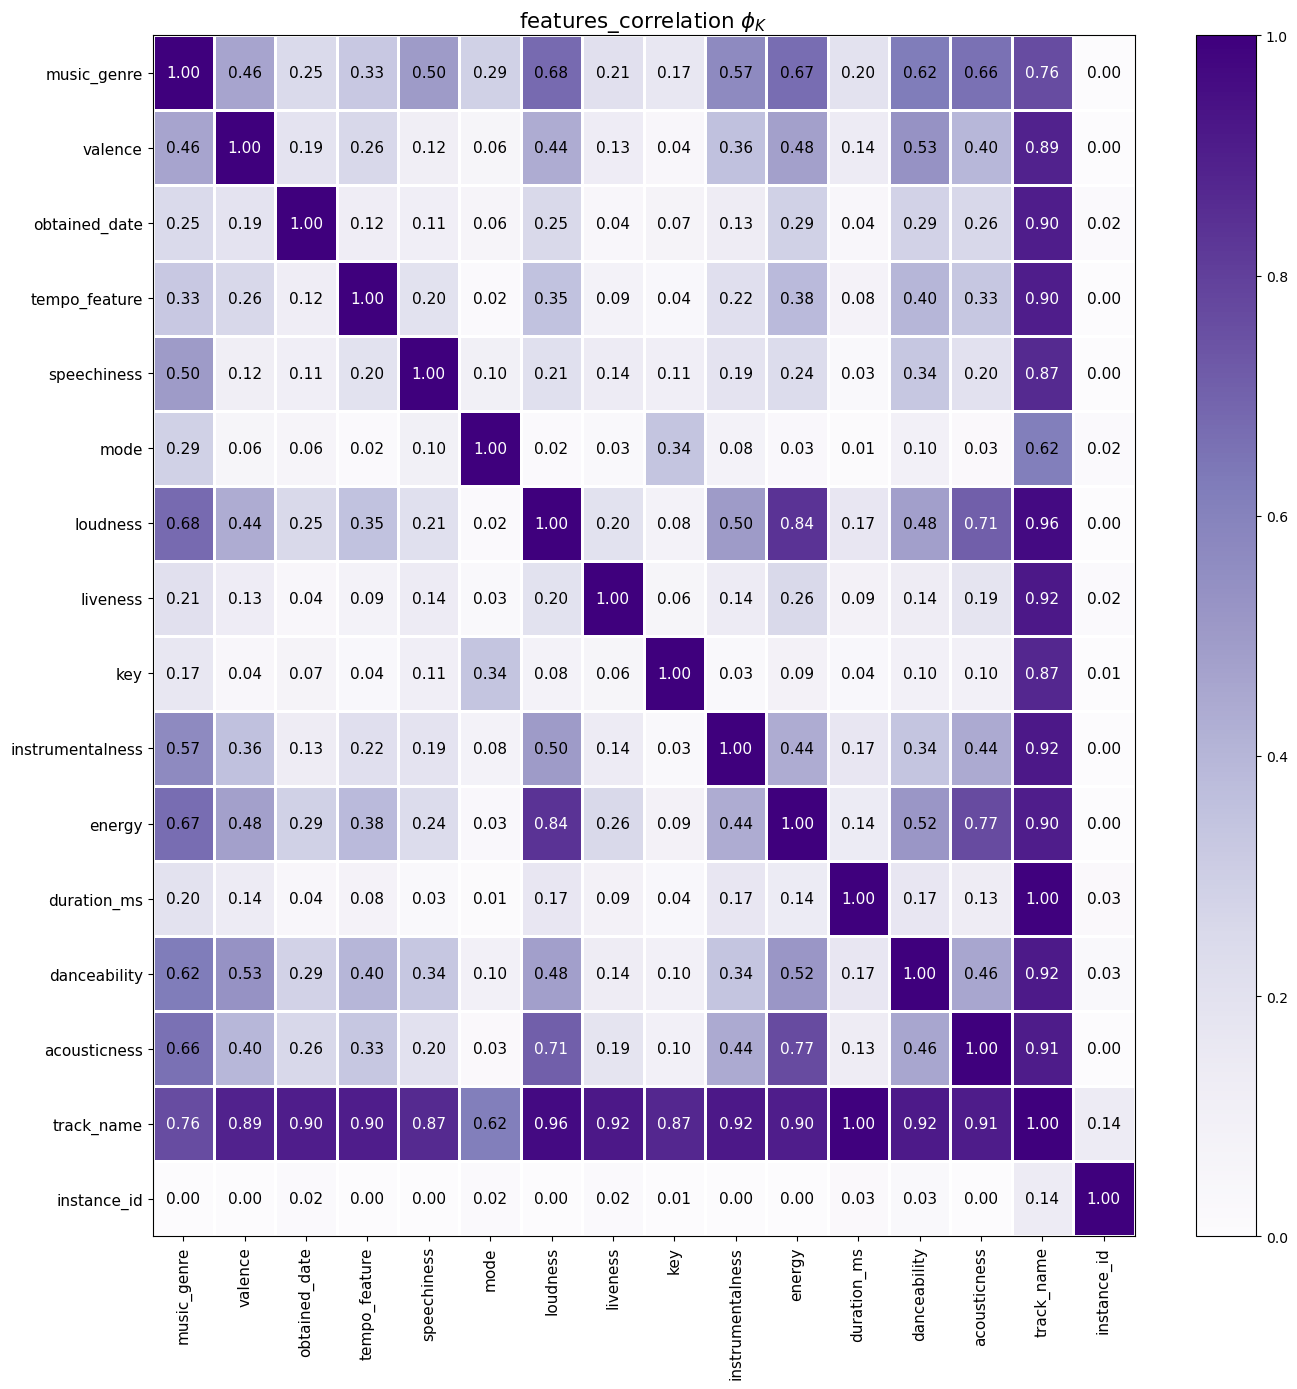

In [49]:
#Визуализация матрицы 𝜙k / 𝜙k matrix visualisation

plot_correlation_matrix(phik_music_df.values, 
                        x_labels=phik_music_df.columns, 
                        y_labels=phik_music_df.index, 
                        vmin=0, vmax=1, color_map="Purples", 
                        title=r"features_correlation $\phi_K$", 
                        fontsize_factor=1.1, 
                        figsize=(14, 14))
plt.tight_layout()

За мультиколлинеарные признаки принято считать фичи с коэффициентом зависимости друг от друга более 0.97. В данном случае они отсутствуют.

- Минимальный коэффициент корреляции составляет 0 (в случае с признаком instance_id).
- Максимальный коэффициент корреляции составляет 0.96. Что Выражает зависимость track_name от loudness.

# Importance analis

In [53]:
features_importances = cbc_model.get_feature_importance(prettified = True).head(20)
features_importances

,Feature Id,Importances
0,instrumentalness,18.317639
1,speechiness,13.054301
2,danceability,12.781055
3,acousticness,10.498691
4,duration_ms,10.023746
5,loudness,8.851252
6,valence,7.406884
7,energy,5.141828
8,track_name,2.947395
9,tempo_feature,1.709894


Ниже проводится анализ только первых 13 признаков, т.к. их коэффициет важности больее 1.

In [51]:
features_list = list(features_importances['Feature Id'])
features_list

['instrumentalness',
 'speechiness',
 'danceability',
 'acousticness',
 'duration_ms',
 'loudness',
 'valence',
 'energy',
 'track_name',
 'tempo_feature',
 'mode',
 'key',
 'obtained_date']

# Model test

## CatBoostClassifier learning. Full data 

In [54]:
%%time
# cbc_model = CatBoostClassifier()
cbc_model = CatBoostClassifier(
    learning_rate = 0.1,
    iterations = 5000,
    loss_function='MultiClass',
    eval_metric = 'MultiClass',
    early_stopping_rounds=50,
    verbose=0,
    random_seed = RANDOM_STATE
)

# Fit model
cbc_model.fit(
    X, y,
    cat_features = cat_features,
    verbose=False
)

CPU times: user 1h 33min 29s, sys: 51.3 s, total: 1h 34min 21s
Wall time: 12min 38s


## Test data preprocessing.

In [57]:
#Change all nan in 'key' column for most frequency key
#самое частое значение в столбце 'key'
most_frequent_key = music_test['key'].mode()[0]

#Замена всех NaN на это значение
music_test['key'] = music_test['key'].fillna(most_frequent_key)


In [58]:
#Change all nan in 'tempo' column for median value
music_test['tempo'] = music_test['tempo'].fillna(music_test['tempo'].mean())



In [61]:
#Change all nan in 'mode' column for median value
#самое частое значение в столбце 'key'
most_frequent_key = music_test['mode'].mode()[0]

#Замена всех NaN на это значение
music_test['mode'] = music_test['mode'].fillna(most_frequent_key)


In [62]:
#Replace all -1 duration for median df duration
music_test.loc[music_test['duration_ms'] == -1, 'duration_ms'] = music_test['duration_ms'].mean()

## Лемметизация текста

In [64]:
#Применение функции очистки к фрейму данных.
tqdm.pandas()
music_test['track_name'] = music_test['track_name'].progress_apply(text_preprocessing)

100%|████████████████████████████████████| 5099/5099 [00:00<00:00, 27404.13it/s]


## Добавление TF-IDF.

In [108]:
#Замена наименования изначального признака 'tempo'
music_test = music_test.rename(columns={'tempo': 'tempo_feature'})

In [109]:
corpus_test = music_test['track_name'].values
# Преобразование тестовых данных в матрицу TF-IDF с использованием уже обученного векторизатора
tf_idf_test = count_tf_idf.transform(corpus_test) 
print(f'Размер матрицы для тестирования: {tf_idf_test.shape}')

Размер матрицы для тестирования: (5099, 10794)


## Добавление признаков TF-IDF  к тестовому фрейму данных

In [115]:
tf_idf_df_test = pd.DataFrame(tf_idf_test.toarray(), columns=count_tf_idf.get_feature_names_out())
tf_idf_df_test

,00,000,001,01,02,03,04,05,06,07,...,zikra,zu,zucar,zul,zum,zuna,zure,zweiten,zz,zzy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5095,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
music_test_tfidf = pd.concat([music_test, tf_idf_df_test], axis = 1)
music_test_tfidf.shape

(5099, 10809)

## Prediction

In [121]:
#Features in accordance with ML features
music_test_predict = music_test_tfidf.drop('instance_id', axis = 1).reset_index(drop=True)
music_test_predict.shape

(5099, 10808)

In [122]:
predict_pool = Pool(data=music_test_predict, cat_features=cat_features)

In [137]:
#Test data predictions
predicted_test = cbc_model.predict(predict_pool)
predicted_test
# Преобразование двумерного массива предсказаний в одномерный
predicted_labels = predicted_test.ravel()
predicted_labels

array(['Rap', 'Blues', 'Rap', ..., 'Rap', 'Electronic', 'Jazz'],
      dtype=object)

In [139]:
# Добавление столбца с предсказаниями к DataFrame
music_test['music_genre'] = predicted_labels


In [145]:
#DF preparation for kaggle loading
music_test_kaggle = music_test.drop(['track_name', 'acousticness', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'speechiness', 'tempo_feature', 'obtained_date', \
                                     'valence'], axis = 1)
music_test_kaggle

#'track_name', , 'is_electronic'

,instance_id,music_genre
0,48564,Rap
1,72394,Blues
2,88081,Rap
3,78331,Country
4,72636,Alternative
...,...,...
5094,50532,Country
5095,26255,Rap
5096,67924,Rap
5097,79778,Electronic




# DF saving as CSV

In [147]:
music_test_kaggle.to_csv(DATA_DIR + 'result_kagle.csv',index=False, index_label=None)

In [152]:
#Добавление результата модели BaseLine:
append_df = pd.DataFrame({
    'ML_model' : ['CatBoostClassifier'],
    'model_description' : ['test prediction'],
    'f1' : [0.54745]})

In [153]:
result_df = pd.concat([result_df, append_df], ignore_index=True)
result_df

,ML_model,model_description,f1
0,CatBoostClassifier,BaseLineModel,0.525201
1,CatBoostClassifier,CatBoostClassifier Model after feature enginee...,0.532850
2,CatBoostClassifier,test prediction,0.547450


# Conclusion

В рамках разведочного анализа была проведена следующая работа:
1) Изучение данных;
2) Анализ выбросов;
3) Заполнение пропусков;
4) формирование новых признаков.

Изучение данных показало наличие пробелов в исходном датасете. Было выявлено, что данные имеют пиковые значения, отличный от средних значений для каждого отдельного жанра. Более того, было обнаружено, что часть данных пропущена.

Анализ датасета и дальнейшая работа с машинным обучением показала, что наличие выбросов в данных не влияет на работу ML модели, более того, исключение ыюросов приводит к ухудшению предсказательной способности модели.
Заполнение пропущенных данных напротив, привело к улучшению качеста модели, как и ожидалось. При восстановлении данных были применены следующие методики:
- Использование медианного и среднего в числовых признаках;
- Определение наиболее частой категории в категориальных признаках.
Значительный вклад в улучшение метрики модели внесли синтетические признаки. Они были разработаны на базе данных, заложенных в названиях треков. К примеру слова, встречающиеся в названиях, такие как 'piano', 'toccata', 'suite' - с огромной долей вероятности относятся к классическому жанру музыки, а 'mix', 'remix' - к электронному.

Более того, в названиях треков содержится много полезных данных, к примеру певцы или уникальные слова, характерные для одного жанра музыки. С помозью технологии NLP получилось сформироваит дополнительные признаки и повысить качество модели.

Применение этой методики увеличивает метрику f1 на 0.1, что в рамках соревнований внесло значимый вклад для достижения лучшей метрики.


До разведочного анализа данных, было выполнено тестовое обучение модели на сырых данных, которое показало метрику F1 = 0.463. После обработки данных была достигнута метрика F1 = 0.54